# Example usage of vrn-unguided-keras.h5
## Modified by Qhan
* Rendering Texture
    * maplotlib.pyplot
    * visvis.mesh
    
* Download the h5py file here:
https://drive.google.com/file/d/1oh8Zpe4wh00iXcm8ztRsi5ZL6GMkHdjj/view?usp=sharing

In [12]:
import warnings
warnings.filterwarnings("ignore")

from keras.models import load_model
import cv2
import visvis as vv
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mcubes
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,10]

import custom_layers

In [2]:
custom_objects = {
    'Conv': custom_layers.Conv,
    'BatchNorm': custom_layers.BatchNorm,
    'UpSamplingBilinear': custom_layers.UpSamplingBilinear
}
model = load_model('vrn-unguided-keras.h5', custom_objects=custom_objects)

## Color Interpolation

In [3]:
def interp(x, v):
    d0, d1 = x, 1-x
    v0, v1 = v
    return (v0 * d1 + v1 * d0)

def interp2d(xy, v):
    x, y = xy
    u = interp(x, v[0])
    d = interp(x, v[1])
    return interp(y, [u, d])

def interpColors(verts, image):
    colors = []
    #im = cv2.GaussianBlur(image, (3, 3), 0)
    for v in verts:
        x, y = v[:2]
        c, r = int(x), int(y)
        corners = im[r:r+2, c:c+2].astype(float) / 256
        colors += [interp2d([x-c, y-r], corners)]
    return colors

## Read Image & Get 3D Model

In [4]:
im = cv2.imread('images/qhan-head-2.png')
im = cv2.resize(im, (192, 192))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img = np.swapaxes(im, 2, 0)
img = np.swapaxes(img, 2, 1)
img = np.array([img])

In [5]:
pred = model.predict(img)
print(pred[0].shape)
vol = pred[0] * 255

(200, 192, 192)


## pyplot trisurf

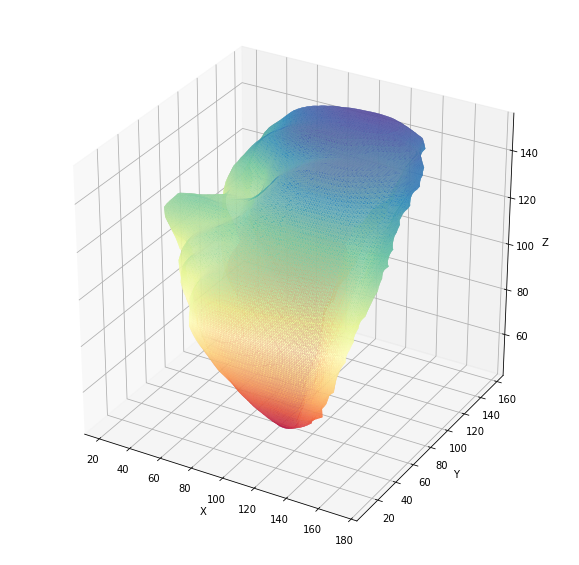

In [9]:
plt.clf()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
verts, faces = mcubes.marching_cubes(vol, 20) # verts: x, y, z

ax.plot_trisurf(192-verts[:, 0], 192-verts[:, 1], faces, verts[:, 2], cmap='Spectral', lw=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## pyplot polygons

In [31]:
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, level=10, step_size=1)
print('vertices:', len(verts), '\nfaces:', len(faces))

# verts: (z, y, x) -> convert to (x, y, z)
x = np.array(verts[:, 2])
verts[:, 2] = np.array(verts[:, 0])
verts[:, 0] = np.array(x)

colors = interpColors(verts, im)

vertices: 107694 
faces: 215384


In [ ]:
plt.clf()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(verts[:, 0], verts[:, 1], color=colors, s=5)

for i, face in enumerate(faces):
    print('\r%d' % i, end='')
    triangle = verts[face]
    mesh = Poly3DCollection([triangle], facecolor=colors[face[0]]) # select one vertice as face color (flat)
    ax.add_collection3d(mesh)

ax.set_xlim(192, 0)
ax.set_ylim(192, 0)
ax.set_zlim(0, 200)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## visvis
In mac OS, visvis demo has some displaying bugs. Check this issue: https://github.com/almarklein/visvis/issues/97

In [14]:
vv.settings.figureSize = (720, 720)

**vv.mesh**

In [15]:
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, level=1, step_size=1)
print('vertices:', len(verts), '\nfaces:', len(faces))

# verts: (z, y, x) -> convert to (x, y, z)
x = np.array(verts[:, 2])
verts[:, 2] = np.array(verts[:, 0])
verts[:, 0] = np.array(x)

vertices: 115932 
faces: 231832


In [ ]:
vv.clf()
f = vv.gcf()

t = vv.imshow(im, interpolate=True)

colors = interpColors(verts, im)
m = vv.mesh(verts, faces, normals, colors)
m.faceShading = 'plain'
m.edgeShading = 'plain'

l = vv.gca()
l.light0.ambient = 0.9 # 0.2 is default for light 0
l.light0.diffuse = 1.0 # 1.0 is default

a = vv.gca()
a.camera.fov = 0 # orthographic
a.camera.roll = 0
a.camera.elevation = 60

# record the result
rec = vv.record(a)

Nangles = 90
for i in range(Nangles):
    a.camera.azimuth = 360 * float(i) / Nangles
    if a.camera.azimuth>180:
        a.camera.azimuth -= 360
    a.Draw() # Tell the axes to redraw
    f.DrawNow() # Draw the figure NOW, instead of waiting for GUI event loop

rec.Stop()
rec.Export('demo.gif')

app = vv.use()
app.Run()

**vv.volshow()**  *(old method)*

In [17]:
volRGB = np.stack(((vol > 1) * im[:,:,0],
                   (vol > 1) * im[:,:,1],
                   (vol > 1) * im[:,:,2]), axis=3)

vv.clf()

t = vv.imshow(im, interpolate=True)
v = vv.volshow3(volRGB, renderStyle='iso')

l = vv.gca()
l.light0.ambient = 0.9 # 0.2 is default for light 0
l.light0.diffuse = 1.0 # 1.0 is default

a = vv.gca()
a.camera.fov = 0 # orthographic

vv.use().Run()

## show z depth layers

In [ ]:
plt.clf()

for i, p in enumerate(volRGB[80:180:5]):
    plt.subplot(5, 4, i + 1)
    plt.imshow(p)
    
plt.show()